In [1]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.colors as clr
%matplotlib inline

In [14]:
def generate_data():
    mean1 = [0,-5]
    mean2 = [0,2.5]
    mean3 = [0,10]
    cov = [1,0],[0,1]
    size = [100]
    data1 = np.random.multivariate_normal(mean1, cov, size)
    data2 = np.random.multivariate_normal(mean2, cov, size)
    data3 = np.random.multivariate_normal(mean3, cov, size)
    labels1 = np.ones((100,1))
    labels2 = np.ones((100,1))*-1
    labels3 = labels1
    data1 = np.hstack((data1, np.ones((100,1)), labels1))
    data2 = np.hstack((data2, np.ones((100,1)),labels2))
    data3 = np.hstack((data3, np.ones((100,1)),labels3))
    data = np.vstack((data1,data2, data3))
    data = shuffle(data)
    return np.transpose(data)

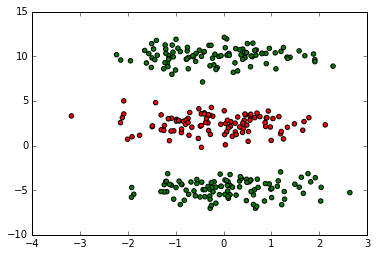

In [16]:
data = generate_data()
colors = ['red','green']
plt.scatter(x = data[0,:], y = data[1,:], c = data[-1,:], cmap=clr.ListedColormap(colors))

In [175]:
class NeuralNet():
    def __init__(self, patterns, response, hidden_nodes, output_nodes):
        self.nodecount = hidden_nodes
        self.response = response
        self.patterns = patterns
        self.output_nodes = output_nodes
        self.errors = []
        
        self.layerone = np.random.normal(0,1,[hidden_nodes,np.shape(patterns)[0]])
        self.layertwo = np.random.normal(0,1,[output_nodes,hidden_nodes+1])
        self.updateone = np.zeros(np.shape(self.layerone))
        self.updatetwo = np.zeros(np.shape(self.layertwo))
                
    def transfer_function(self, value):
        f = np.vectorize(lambda x: 2/(1+np.exp(-x))-1)
        return f(value)
    
    def transfer_derivative(self, value):
        f = self.transfer_function(value)
        return np.divide(np.multiply(1+f,1-f),2)
        
    def forward_pass(self, patterns):
        bias = np.ones((1,np.shape(patterns)[1]))
        hin = np.dot(self.layerone, patterns)
        hout = np.vstack((self.transfer_function(hin), bias))
        
        oin = np.dot(self.layertwo, hout)
        oout = self.transfer_function(oin)
        return hout, oout
    
    def backwards_pass(self, hout, oout):   
        delta_out  = np.multiply((oout - self.response),self.transfer_derivative(oout))
        delta_hidden = np.multiply(np.dot(np.transpose(self.layertwo), delta_out),
                                   self.transfer_derivative(hout))[:-1,:]
        return delta_out, delta_hidden
    
    def update_weights(self, learning_rate, momentum):
        hout, oout = self.forward_pass(self.patterns)
        delta_out, delta_hidden = self.backwards_pass(hout, oout)
        
        self.updateone = np.multiply(momentum,self.updateone)-np.multiply((1-momentum),np.dot(delta_hidden,np.transpose(self.patterns)))
        self.updatetwo = np.multiply(momentum,self.updatetwo)-np.multiply((1-momentum),np.dot(delta_out, np.transpose(hout)))
        
        self.layerone += np.multiply(learning_rate,self.updateone)
        self.layertwo += np.multiply(learning_rate,self.updatetwo)
        
    def calculate_mse(self, patterns, response, classification = True):
        prediction = self.predict(patterns, classification)
        error = np.square(prediction - response)
        return np.average(error)
    
    def predict(self, patterns, classification = True):
        _ , prediction = self.forward_pass(patterns)
        if classification:
            prediction[prediction > 0] = 1
            prediction[prediction <= 0] = -1
        return prediction
    
    def train(self, iterations, learning_rate, momentum, classification = True):
        for iteration in range(iterations):
            self.update_weights(learning_rate, momentum)
            error = self.calculate_mse(self.patterns, self.response, classification)
            self.errors.append(error)
            
    def plot_decision_boundary(self, points = True, h = 0.1):
        x_min, x_max = self.patterns[0, :].min() - 1, self.patterns[0, :].max() + 1
        y_min, y_max = self.patterns[1, :].min() - 1, self.patterns[1, :].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
        grid_data = np.transpose(np.c_[xx.ravel(), yy.ravel()])
        ones = np.transpose(np.ones((np.shape(xx)[1]*np.shape(xx)[0],1)))
        grid_data = np.vstack((grid_data,ones))
        Z = self.predict(grid_data)
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        if points:
            plt.scatter(self.patterns[0, :], self.patterns[1, :], c = self.response, cmap=clr.ListedColormap(['red','green']))
        plt.show()


In [205]:
network = NeuralNet(data[:-1,:], data[-1,:], 15, 1)

In [206]:
network.train(100,0.001,0.5)

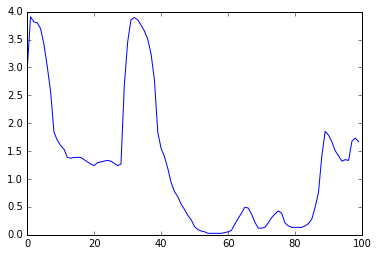

In [207]:
plt.plot(network.errors)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


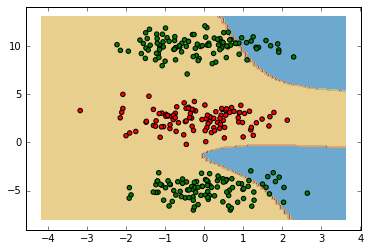

In [208]:
network.plot_decision_boundary()